<a href="https://colab.research.google.com/github/shaniaking/Sentiment-Analysis-DS340W/blob/main/Sentiment_Analysis_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/nisargchodavadiya/imdb-movie-reviews-with-ratings-50k?select=imdb_sup.csv

In [1]:
#Import Libraries
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay
)

In [2]:
#Load Dataset
df = pd.read_csv("imdb_dataset.csv")
df = df.drop_duplicates(subset=["Review", "Rating"]).reset_index(drop=True)

#Label Data
X = df["Review"]
y = df["Rating"]

#Split Data into Training, Testing, and Validation
X_temp, X_validation, y_temp, y_validation = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)

#Print Split Sizes
print(f"Training Data: {len(X_train)}")
print(f"Testing Data: {len(X_test)}")
print(f"Validation Data: {len(X_validation)}")

Training Data: 34809
Testing Data: 9818
Validation Data: 4959


In [3]:
#Preproccessing
try:
  stop_words = set(stopwords.words('english'))
except LookupError:
  nltk.download('stopwords', quiet=True)
  stop_words = set(stopwords.words('english'))

def preprocess_review(text):
    text = text.lower() #Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)) #Remove Punctuation
    words = text.split() #Split
    filtered = [word for word in words if word not in stop_words] #Remove Stopwords
    text = ' '.join(filtered) #Join
    return text

X_train = X_train.apply(preprocess_review)
X_test = X_test.apply(preprocess_review)
#X_val = X_val.apply(preprocess_review) #Kept unseen

#Show review rows
print(X_train.head())
print(X_test.head())

3345     arms man one shaws funniest plays handled corr...
3325     shinjuku triad society chinese mafia wars unli...
25387    chucky murderous doll childs play 2 crappy seq...
22821    rented film purely fact cover appealed however...
21542    well one say firstly adaptation far long 4 hou...
Name: Review, dtype: object
4151     thought movie dont fantastic past ive watched ...
48936    pretty lame awful slasher someone killing memb...
46571    500 budget bottle ketchupbr br fan c movies ta...
19347    four porn stars romping irish woods sounds lik...
20805    br br main question pose concerning film film ...
Name: Review, dtype: object


In [4]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)

#Transform test set
X_test_tfidf = vectorizer.transform(X_test)

#Validation set remains untouched until final evaluation
#X_val_tfidf = vectorizer.transform(X_val)

In [5]:
#Creating Buckets
def buckets(rating):
    if rating >= 9:
        return "Overwhelmingly Positive"
    elif rating >= 7:
        return "Mostly Positive"
    elif rating >= 3:
        return "Mostly Negative"
    else:
        return "Overwhelmingly Negative"

y_train_bucketed = y_train.apply(buckets)
y_test_bucketed = y_test.apply(buckets)
#y_validation_bucketed = y_validation.apply(buckets)

In [6]:
#Logistic Regression Model
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_tfidf, y_train_bucketed)
lr_preds = lr_model.predict(X_test_tfidf)

print("Logistic Regression Results:\n")
print(classification_report(y_test_bucketed, lr_preds))

Logistic Regression Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.57      0.48      0.52      2053
        Mostly Positive       0.55      0.50      0.52      2068
Overwhelmingly Negative       0.71      0.77      0.74      2790
Overwhelmingly Positive       0.68      0.75      0.71      2907

               accuracy                           0.65      9818
              macro avg       0.63      0.62      0.62      9818
           weighted avg       0.64      0.65      0.64      9818



In [7]:
#Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train_bucketed)
rf_preds = rf_model.predict(X_test_tfidf)

print("Random Forest Results:\n")
print(classification_report(y_test_bucketed, rf_preds))

Random Forest Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.58      0.21      0.31      2053
        Mostly Positive       0.56      0.29      0.38      2068
Overwhelmingly Negative       0.59      0.83      0.69      2790
Overwhelmingly Positive       0.58      0.81      0.68      2907

               accuracy                           0.58      9818
              macro avg       0.58      0.53      0.51      9818
           weighted avg       0.58      0.58      0.54      9818



In [8]:
#Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_bucketed)
dt_preds = dt_model.predict(X_test_tfidf)

print("Decision Tree Results:\n")
print(classification_report(y_test_bucketed, dt_preds))

Decision Tree Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.32      0.30      0.31      2053
        Mostly Positive       0.31      0.31      0.31      2068
Overwhelmingly Negative       0.52      0.53      0.53      2790
Overwhelmingly Positive       0.50      0.52      0.51      2907

               accuracy                           0.43      9818
              macro avg       0.41      0.41      0.41      9818
           weighted avg       0.43      0.43      0.43      9818



In [9]:
#Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_bucketed)
nb_preds = nb_model.predict(X_test_tfidf)

print("Naive Bayes Results:\n")
print(classification_report(y_test_bucketed, nb_preds))

Naive Bayes Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.59      0.31      0.41      2053
        Mostly Positive       0.54      0.39      0.45      2068
Overwhelmingly Negative       0.62      0.82      0.71      2790
Overwhelmingly Positive       0.63      0.78      0.70      2907

               accuracy                           0.61      9818
              macro avg       0.60      0.57      0.57      9818
           weighted avg       0.60      0.61      0.59      9818



In [10]:
#K-Nearest Neighbors Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train_bucketed)
knn_preds = knn_model.predict(X_test_tfidf)

print("K-Nearest Neighbors Results:\n")
print(classification_report(y_test_bucketed, knn_preds))

K-Nearest Neighbors Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.36      0.35      0.35      2053
        Mostly Positive       0.36      0.42      0.39      2068
Overwhelmingly Negative       0.53      0.54      0.54      2790
Overwhelmingly Positive       0.54      0.49      0.51      2907

               accuracy                           0.46      9818
              macro avg       0.45      0.45      0.45      9818
           weighted avg       0.46      0.46      0.46      9818



In [11]:
#Support Vector Machine Model
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train_bucketed)
svm_preds = svm_model.predict(X_test_tfidf)

print("Support Vector Machine Results:\n")
print(classification_report(y_test_bucketed, svm_preds))

Support Vector Machine Results:

                         precision    recall  f1-score   support

        Mostly Negative       0.53      0.46      0.49      2053
        Mostly Positive       0.49      0.48      0.48      2068
Overwhelmingly Negative       0.70      0.74      0.72      2790
Overwhelmingly Positive       0.66      0.70      0.68      2907

               accuracy                           0.61      9818
              macro avg       0.59      0.59      0.59      9818
           weighted avg       0.61      0.61      0.61      9818



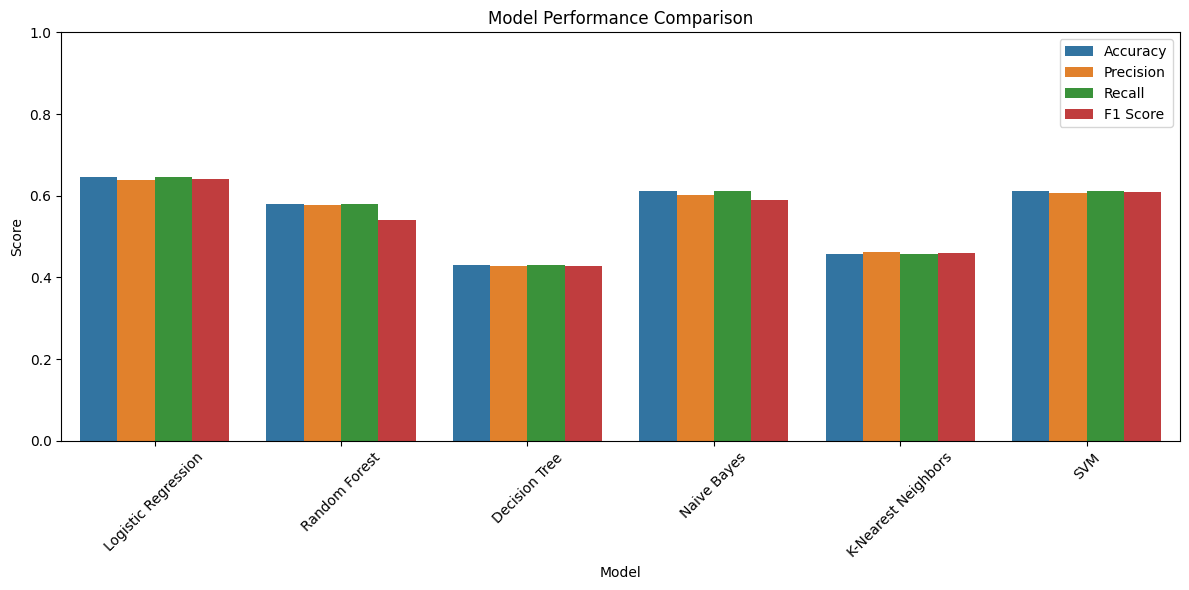

In [12]:
#Collect Predictions
model_preds = {
    "Logistic Regression": lr_preds,
    "Random Forest": rf_preds,
    "Decision Tree": dt_preds,
    "Naive Bayes": nb_preds,
    "K-Nearest Neighbors": knn_preds,
    "SVM": svm_preds
}

#Initialize Metric Containers
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

#Compute Metrics
for name, preds in model_preds.items():
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test_bucketed, preds))
    metrics["Precision"].append(precision_score(y_test_bucketed, preds, average='weighted', zero_division=0))
    metrics["Recall"].append(recall_score(y_test_bucketed, preds, average='weighted'))
    metrics["F1 Score"].append(f1_score(y_test_bucketed, preds, average='weighted'))

#Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

#Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

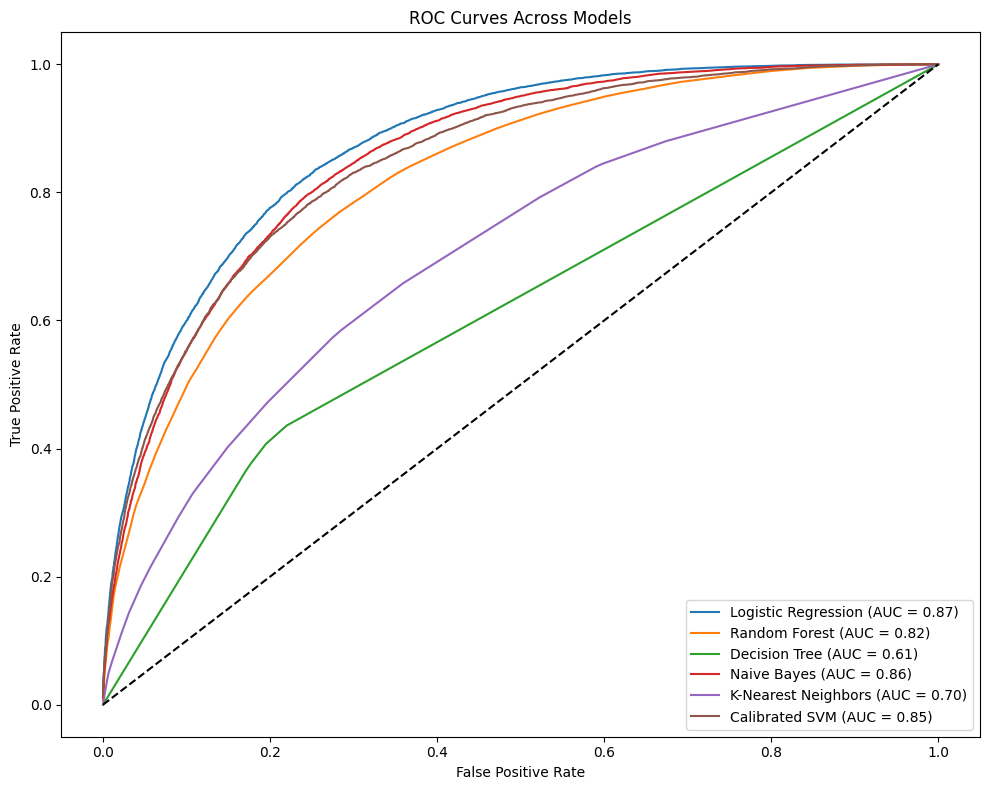

In [17]:
#Binarize Test Labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_bucketed)

#Calibrate SVM
svm_model_calibrated = CalibratedClassifierCV(svm_model)
svm_model_calibrated.fit(X_train_tfidf, y_train_bucketed)

def plot_avg_roc(models, model_names, X_test_tfidf, y_test_bin, lb):
    plt.figure(figsize=(10, 8))
    for model, name in zip(models, model_names):
        probs = model.predict_proba(X_test_tfidf)

        #Compute ROC For Each Class
        fpr_dict, tpr_dict, auc_dict = {}, {}, {}
        for i in range(len(lb.classes_)):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

        #Interpolate All ROC Curves
        all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(lb.classes_))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(lb.classes_)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
        mean_tpr /= len(lb.classes_)
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves Across Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

models = [
    lr_model,
    rf_model,
    dt_model,
    nb_model,
    knn_model,
    svm_model_calibrated
]
model_names = [
    "Logistic Regression",
    "Random Forest",
    "Decision Tree",
    "Naive Bayes",
    "K-Nearest Neighbors",
    "Calibrated SVM"
]

#Plot ROC Curves
plot_avg_roc(models, model_names, X_test_tfidf, y_test_bin, lb)